统计数据集数量

In [13]:
import json

datasets_path = r"../merged_output_20230812_190843.json"

# 读取并解析 JSON 文件
with open(datasets_path, 'r') as f:
    data = json.load(f)

# 计算并打印字典的数量
print(len(data))

4705


统计数据集token后的长度

In [14]:
from dataclasses import dataclass, field

import transformers
from accelerate import Accelerator
from typing import Optional
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
import sys
sys.path.append('../../')


from trainers.accelerateTrainer import AccelerateTrainer
from util.translation_dataset import get_train_dataset
from datetime import datetime

In [15]:
tokenizer = AutoTokenizer.from_pretrained(
    "bigscience/bloomz-560m",
    use_fast=False,
)

In [16]:
def preprocess(
    source,
    target,
    tokenizer: transformers.PreTrainedTokenizer,
):
    """Preprocess the data by tokenizing."""
    example = source + target
    return tokenizer(example)

In [17]:
PROMPT_DICT = {
    "prompt_input": (
        "下面是一段文言文文本，请将它翻译成白话文。\n"
        "{terms}"
        "#文言文文本:\n{input}\n\n#白话文:\n"
    ),
}

def make_prompt(example, tokenizer):
    terms = example.get("terms", "")
    terms_prompt = ""
    if terms:
        terms_prompt = "#需应用术语:\n"
        for term in terms:
            terms_prompt += f"{term['src']}\t{term['tag']}\t{term['tgt']}\n"

    source = PROMPT_DICT["prompt_input"].format(
        input=example["input"], terms=terms_prompt
    )
    target = f"{example['output']}{tokenizer.eos_token}"
    return source, target

In [18]:
import datasets
from torch.utils.data import Dataset
from typing import Dict
import torch

class SupervisedDataset(Dataset):
    """Dataset for supervised fine-tuning."""

    def __init__(self, data_path: str, tokenizer: transformers.PreTrainedTokenizer, make_prompt=None, num_proc=1):
        super(SupervisedDataset, self).__init__()
        dataset = datasets.load_dataset("json", data_files=data_path)
        tokenizeddata = dataset.map(lambda x: preprocess(
            *make_prompt(x, tokenizer), tokenizer),
            num_proc=num_proc,
            remove_columns=["input", "output", "terms"]
        )
        self.data = tokenizeddata["train"]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return self.data[i]

def get_train_dataset(tokenizer, data_path, accelerator=None):
    train_dataset = SupervisedDataset(
        tokenizer=tokenizer, data_path=data_path, make_prompt=make_prompt, num_proc=4)
    return train_dataset

In [19]:
#  定义数据集
data_path=datasets_path
print("-"*100)
print(f"data_path: {data_path}")
train_dataset = get_train_dataset(tokenizer, data_path)

----------------------------------------------------------------------------------------------------
data_path: /Users/timvan/Desktop/xm/trans_ancient_chn/data/merged_output_20230807_055259.json


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 35.46it/s]


Dataset json downloaded and prepared to /Users/timvan/.cache/huggingface/datasets/json/default-a2eb3731773b469c/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 16.77it/s]


In [20]:
print("-"*100)
print("打印数据集信息")
# 打印数据集信息
print(f"len(train_dataset): {len(train_dataset)}")

for i in range(3):
    print(f"decoder_input_ids: {tokenizer.decode(train_dataset[i]['input_ids'])}")
    print("-*"*10)
print("-"*100)

----------------------------------------------------------------------------------------------------
打印数据集信息
len(train_dataset): 4705
decoder_input_ids: 下面是一段文言文文本，请将它翻译成白话文。
#文言文文本:
初，安禄山有边功，帝宠之，诏与诸姨约为兄弟，而禄山母事妃，来朝，必宴饯结欢。禄山反，以诛国忠为名，且指言妃及诸姨罪。帝欲以皇太子抚军，因禅位，诸杨大惧，哭于廷。国忠入白妃，妃衔块请死，帝意沮，乃止。及西幸至马嵬，陈玄礼等以天下计诛国忠，已死，军不解。帝遣力士问故，曰：“祸本尚在！”帝不得已，与妃诀，引而去，缢路祠下，裹尸以紫茵，瘗道侧，年三十八。

#白话文:
起初，安禄山有边功，皇帝宠信他，命他与杨家诸姨结为兄妹，而禄山则拜贵妃为母，禄山每次来京朝见天子，杨家人必定设宴招待，同他建立友好关系。后来安禄山造反，以讨伐杨国忠为借口，而且公开指出贵妃及杨家诸姨的罪恶。皇帝想让皇太子率军随从自己出征，接着把帝位禅让给他，杨家诸人极为恐惧，聚在庭院里痛哭。国忠入宫禀告贵妃，贵妃口衔土块请求天子将自己处死，皇帝心情沮丧，于是便没有那样做。等到潼关失守，玄宗西行到了马嵬驿，陈玄礼等就为天下人考虑杀掉国忠，但国忠已死，军队将士仍不散去。皇帝派高力士询问原因，将士们说：“祸乱的根子还在！”皇帝不得已，与贵妃诀别，让人把她带走，勒死在路旁的祠庙，用紫色褥子裹尸，埋在大路边，这时贵妃三十八岁。</s>
-*-*-*-*-*-*-*-*-*-*
decoder_input_ids: 下面是一段文言文文本，请将它翻译成白话文。
#文言文文本:
遂进逼都城。

#白话文:
于是杨玄感率兵进逼东都洛阳城。</s>
-*-*-*-*-*-*-*-*-*-*
decoder_input_ids: 下面是一段文言文文本，请将它翻译成白话文。
#文言文文本:
保定初，以孝宽立勋玉壁，遂于玉壁置勋州，仍授勋州刺史。齐人遣使至玉壁，求通互市。晋公护以其相持日久，绝无使命，一日忽来求交易，疑别有故。又以皇姑、皇世母先没在彼，因其请和之际，或可致之。遂令司门下大夫尹公正至玉壁，共孝宽详议。孝宽乃于郊盛设供帐，令公正接对使人，兼论皇家亲属在东之意。使者

可视化input_ids长度的分布，并且使用Numpy库来计算覆盖98%数据的长度值

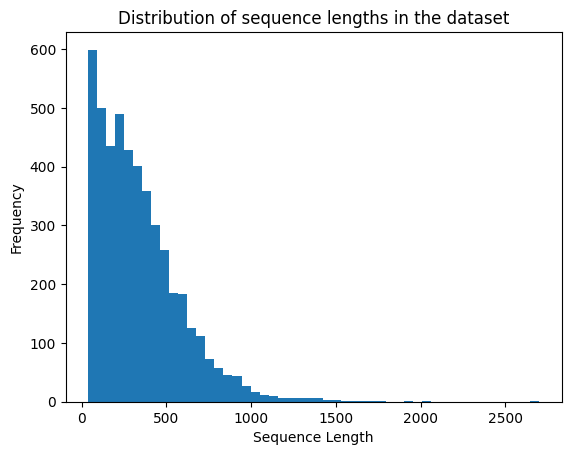

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 计算所有输入的长度
lengths = [len(item['input_ids']) for item in train_dataset]

# 绘制长度的直方图
plt.hist(lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of sequence lengths in the dataset')
plt.show()

In [22]:
# 计算覆盖98%数据的长度值
lengths = np.array(lengths)
max_length_98_percentile = np.percentile(lengths, 98)
print(f"The length value that covers 98% of the data is {max_length_98_percentile}")

The length value that covers 98% of the data is 969.9200000000001
